# Modelos de Clasificación 

## 1. Librerias y configuraciones previas


In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
import math

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split


#Escalar Variables
from sklearn.preprocessing import MinMaxScaler


#Evaluación del modelo
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA # Análisis de Componentes Principales
from sklearn.decomposition import KernelPCA # Kernel PCA
from sklearn.decomposition import SparsePCA # PCA esparcido
from sklearn.decomposition import MiniBatchSparsePCA # Mini Batch PCA esparcido
from sklearn.utils.extmath import safe_sparse_dot # Producto punto entre matrices esparcidos para SparsePCA.
from sklearn.decomposition import IncrementalPCA # PCA incremental
from sklearn.decomposition import FastICA # Análisis de Componentes Independientes
from sklearn.random_projection import johnson_lindenstrauss_min_dim, GaussianRandomProjection, SparseRandomProjection
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE # TSNE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
#import dmba as dm


from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


#Creación de modelos
from sklearn import svm
from sklearn import neighbors
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import ComplementNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## 2. Funciones

In [2]:
# Función para graficar un plot con multiples gráficas del mismo tipo:
#
# df       : dataframe 
# cols     : lista de columnas a graficar
# num_cols : número de columnas 
# num_rows : número de filas
# tipo     : 'c' = countplot,   'b' = boxplot, 's' = scatterplot 
# targetVar: nombre de la variable comparativa de salida. Debe ser numérica y debe estar cotenida en el dataframe. 
#            Para countplot no es necesario (None)
# figsize  : tamaño del plot. Valor por defecto (16,8)
#
# *Nota: el número de filas * el número de columnas debe ser mayor al total de elementos de cols
#
# Ejemplos:     
#    plot_multiples_graficas (d, catCols, 5, 3, 'c', None, (16,12))
#    plot_multiples_graficas (d, numCols, 5, 3, 's', 'price', (16,12))
# ==============================================================================


def plot_multiples_graficas(df, cols, num_cols, num_rows, tipo, targetVar, figsize=(16,8)):
    
    plt.rcParams['figure.figsize'] = figsize
    
    #num_plots = len(cols)
    #num_cols = math.ceil(np.sqrt(num_plots))
    #num_rows = math.ceil(num_plots/num_cols)
        
    fig, axs = plt.subplots(num_rows, num_cols)
    
    for ind, col in enumerate(cols):
        i = math.floor(ind/num_cols)
        j = ind - i*num_cols
        
        if num_rows == 1:
            if num_cols == 1:
                if tipo == 'c': 
                    sns.countplot(x=df[col], ax=axs, dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df.targetVar, ax=axs)
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df.targetVar, ax=axs)
            else:
                if tipo == 'c':
                    sns.countplot(x=df[col], ax=axs[j], dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs[j])
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs[j])
        else:
            if tipo == 'c':
                sns.countplot(x=df[col], ax=axs[i, j], dodge = False)
            if tipo == 'b':
                sns.boxplot(x=df[col], y=df[targetVar], ax=axs[i, j])
            if tipo == 's':
                sns.scatterplot(x=df[col], y=df[targetVar], ax=axs[i, j])
#plt.xticks(tick_marks, classes, rotation=45)

In [3]:
# Funcion para imprimir la curva ROC

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

## 3. Carga del dataset

In [4]:
#Se crea un dataframe d con los datos obtenidos de archivo de entrada
d = pd.read_csv("./Nacimientobalanceadologistica.csv")

In [5]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32110 entries, 0 to 32109
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   AREANAC     32110 non-null  object 
 1   SIT_PARTO   32110 non-null  object 
 2   SEXO        32110 non-null  object 
 3   MES         32110 non-null  float64
 4   ATEN_PAR    32110 non-null  object 
 5   T_GES       32110 non-null  float64
 6   NUMCONSUL   32110 non-null  float64
 7   TIPO_PARTO  32110 non-null  object 
 8   MUL_PARTO   32110 non-null  object 
 9   IDHEMOCLAS  32110 non-null  object 
 10  IDFACTORRH  32110 non-null  object 
 11  EDAD_MADRE  32110 non-null  float64
 12  EST_CIVM    32110 non-null  object 
 13  NIV_EDUM    32110 non-null  object 
 14  N_HIJOSV    32110 non-null  float64
 15  N_EMB       32110 non-null  float64
 16  SEG_SOCIAL  32110 non-null  object 
 17  EDAD_PADRE  32110 non-null  float64
 18  NIV_EDUP    32110 non-null  object 
 19  COMUNA_RES  32110 non-nul

In [6]:
#Reemplazo de valores para la agrupación de categorías

d["BAJO_PESO"].replace("NO",0,inplace=True)
d["BAJO_PESO"].replace("SI",1,inplace=True)

# Cambiar el tipo de datos de object a float
d['BAJO_PESO'] = d['BAJO_PESO'].astype('int')

## 4. Visualización de datos

### Variables de entrada

In [7]:
#Lista de variables numéricas

numCols=d.select_dtypes(include = ['float64','float64','int32','int64']).columns.tolist()

d[numCols].head()

,MES,T_GES,NUMCONSUL,EDAD_MADRE,N_HIJOSV,N_EMB,EDAD_PADRE,BAJO_PESO
0,2.0,39.0,8.0,27.0,1.0,1.0,29.0,0
1,4.0,38.0,8.0,23.0,2.0,2.0,22.0,0
2,6.0,39.0,8.0,21.0,1.0,1.0,21.0,0
3,4.0,40.0,7.0,34.0,2.0,2.0,31.0,0
4,12.0,40.0,10.0,19.0,2.0,2.0,21.0,0


In [8]:
#Eliminar la variable de salida de la lista de variable numéricas
numCols.remove('BAJO_PESO')

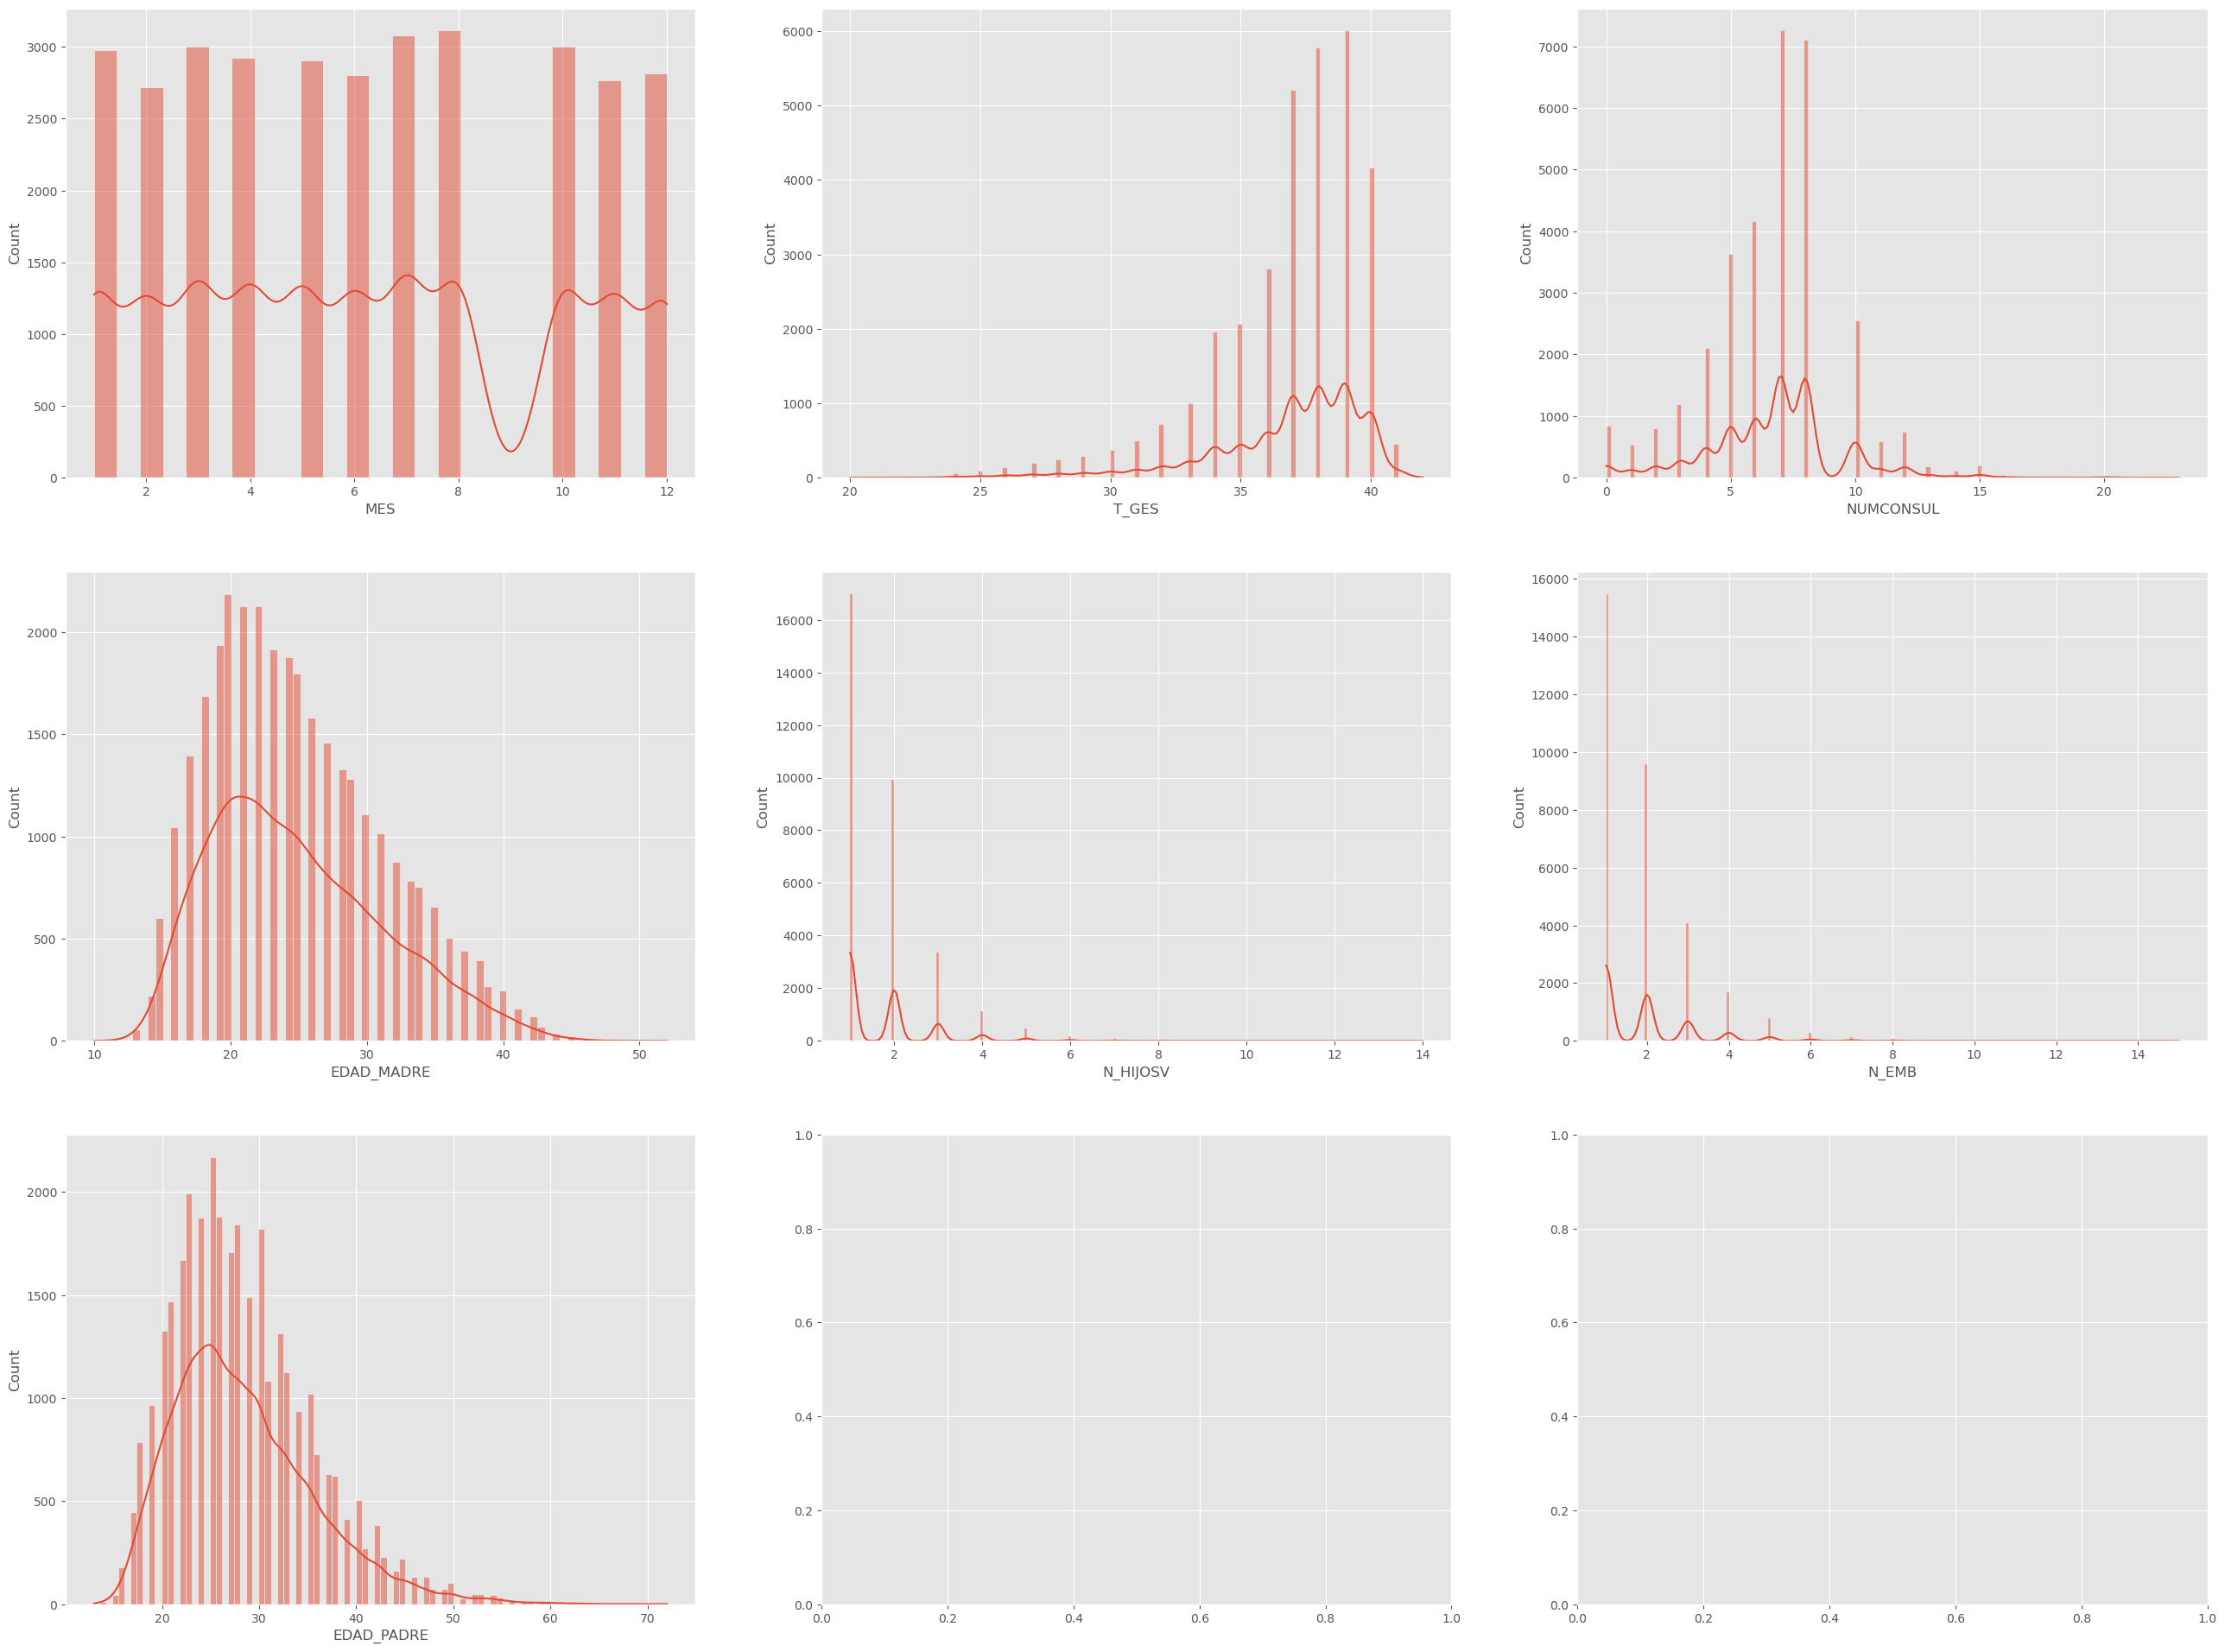

In [9]:
#Matriz de gráficos de histograma de todas las variables de entrada

# Se establecen la cantidad de columnas y filas para la matriz de gráficos
num_cols = 3
num_rows = 3

# Configuración del tamaño de la figura
figsize=(32,24)
plt.rcParams['figure.figsize'] = figsize
        
# Creación de la figura y los ejes
fig, axs = plt.subplots(num_rows, num_cols)

# Iteración sobre las columnas numéricas
for ind, col in enumerate(numCols):
    
    # Cálculo de las coordenadas de subtrama
    i = math.floor(ind/num_cols)
    j = ind - i*num_cols
    
    # Creación del histograma con estimación de densidad de kernel
    sns.histplot(d[col], ax=axs[i, j], kde=True)

### Variable de salida

In [10]:
# Distriución de la variable de salida

d['BAJO_PESO'].value_counts()

0    16055
1    16055
Name: BAJO_PESO, dtype: int64

## 5. Preparación de datos

### Creación de Variables Dummies

In [11]:
# Aplicación de la función de get_dummies

df =pd.get_dummies(d, drop_first=1)

### Dividir el conjunto de datos

In [12]:
#Se crea una lista con todas las varibles de entrada

vDep = list(df.columns)
vDep.remove('BAJO_PESO')

print(vDep)

['MES', 'T_GES', 'NUMCONSUL', 'EDAD_MADRE', 'N_HIJOSV', 'N_EMB', 'EDAD_PADRE', 'AREANAC_Centro Poblado', 'AREANAC_Rural disperso', 'SIT_PARTO_Institución de salud', 'SIT_PARTO_Otro', 'SEXO_Masculino', 'ATEN_PAR_Enfermero(a)', 'ATEN_PAR_Medico', 'ATEN_PAR_Otro', 'ATEN_PAR_Promotor(a) de salud', 'TIPO_PARTO_Espontáneo', 'TIPO_PARTO_Instrumentado', 'MUL_PARTO_Doble', 'MUL_PARTO_Triple', 'MUL_PARTO_simple', 'IDHEMOCLAS_AB', 'IDHEMOCLAS_B', 'IDHEMOCLAS_O', 'IDFACTORRH_Positivo', 'EST_CIVM_No  casada y pareja > 2años ', 'EST_CIVM_No casada y pareja < 2años', 'EST_CIVM_Separada, divorciada', 'EST_CIVM_Soltera', 'EST_CIVM_Viuda', 'NIV_EDUM_Especializacion', 'NIV_EDUM_Maestria', 'NIV_EDUM_Media academica', 'NIV_EDUM_Media técnica', 'NIV_EDUM_Ninguana', 'NIV_EDUM_Normalista', 'NIV_EDUM_Prescolar', 'NIV_EDUM_Primaria', 'NIV_EDUM_Secundaria', 'NIV_EDUM_Tecnológica', 'NIV_EDUM_Técnica profesional', 'SEG_SOCIAL_Excepción', 'SEG_SOCIAL_No asegurado', 'SEG_SOCIAL_Subsidiado', 'SEG_SOCIAL_contributivo'

In [13]:
# División de los datos en train y test


# Se establecen los dataframes de con las variables de entrada X y la variable de salida y
X = df[vDep]
y = df['BAJO_PESO']

In [14]:
#Escalar Variables

# Se establece la configuración para que los valores numéricos se vean con 4 decimales
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Se crea un objeto MinMaxScaler
scaler = MinMaxScaler()
# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X[numCols] = scaler.fit_transform(X[numCols])
X.head()

,MES,T_GES,NUMCONSUL,EDAD_MADRE,N_HIJOSV,N_EMB,EDAD_PADRE,AREANAC_Centro Poblado,AREANAC_Rural disperso,SIT_PARTO_Institución de salud,...,COMUNA_RES_13 San Javier,COMUNA_RES_14 El Poblado,COMUNA_RES_15 Guayabal,COMUNA_RES_16 Belen,COMUNA_RES_50 Corregimiento de Palmitas,COMUNA_RES_60 Corregimiento de San Cristobal,COMUNA_RES_70 Corregimiento de Altavista,COMUNA_RES_80 Corregimiento de San Antonio de Prado,COMUNA_RES_90 Corregimiento de Santa Elena,COMUNA_RES_Sin informacion
0,0.0909,0.8636,0.3478,0.4048,0.0000,0.0000,0.2712,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0.2727,0.8182,0.3478,0.3095,0.0769,0.0714,0.1525,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0.4545,0.8636,0.3478,0.2619,0.0000,0.0000,0.1356,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0.2727,0.9091,0.3043,0.5714,0.0769,0.0714,0.3051,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1.0000,0.9091,0.4348,0.2143,0.0769,0.0714,0.1356,0,0,1,...,1,0,0,0,0,0,0,0,0,0


## Reducción de dimensionalidad

Una vez realizado la exploración de datos del item anterior, se procede a transformar los datos originales en datos reducidos o embebidos a partir de los algoritmo de reducción de dimensionalidad. Se sugiere utilizar mínimo tres métodos de reducción de dimensionalidad para seleccionar los datos reducidos con el error cuadrático medio más bajo.

### Análisis de Componentes Principales (PCA)

In [15]:
Num_Componentes = X.shape[1] # estamos trabajando con el numero de componentes igual al numero de

pca = PCA(iterated_power='auto', n_components = Num_Componentes, random_state = 17, svd_solver='auto', tol = 1e-3, whiten = False)

# El número de componentes debe ser menor o igual al número de características de los datos.

# Calcular los valores de las componentes principales iterated_power es el número de iteraciones para el método computacional de PCA. 
# Usualmente, es aleatorio el número de iteraciones.
# n_components es el número de componentes principales
# random_state es la semilla de un número aleatorio. Si random_state = 'None', significa que el generador de números
# aleatorios es una muestra de un estado aleatorio usado por np.random. Si random_state = 'Int', entonces el estado aleatorio
# es la semilla usado por el generador de números aleatorios. Sugiero usar la primera opción.
# svd_solver es el método de solución de PCA. Por defecto, se usa svd_solver = "auto" pero pueden seleccionar "full",
# "arpack" o "randomized". Para más opciones de PCA, recomiendo visitar la siguiente url: 
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.

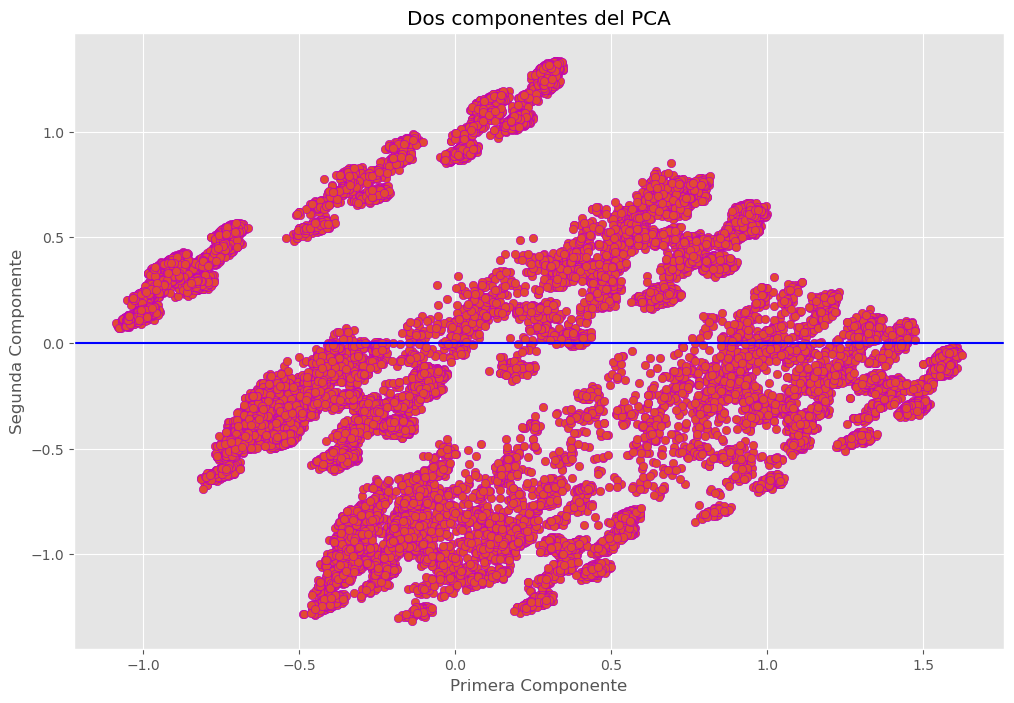

In [16]:
Variables_Principales = pca.fit_transform(X) 
# Transformarmos las componentes principales a partir de los datos

fig = plt.figure(figsize=(12,8)) # Se define el tamaño de la figura en ancho y altura

plt.scatter(Variables_Principales[:,0], Variables_Principales[:,1], edgecolors="m")
plt.axhline(0, color="blue") # Elegir color de la linea horizontal de referencia
plt.title('Dos componentes del PCA') # Titulo de la gráfica
plt.xlabel('Primera Componente') # Etiqueta del eje x
plt.ylabel('Segunda Componente') # Etiqueta del eje y
plt.show() # Mostrar figura

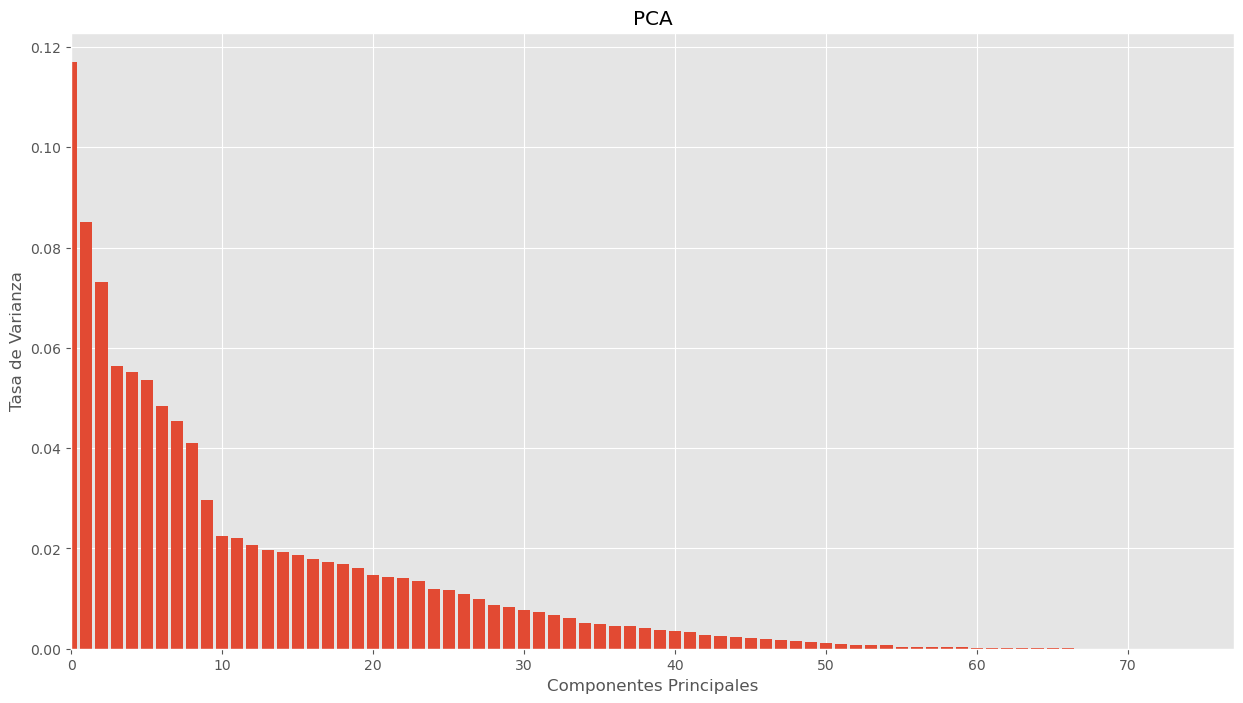

In [17]:
Varianza = pca.explained_variance_ratio_ # Calculamos la tasa de varianza de las componentes y generamos las componentes principales

fig = plt.figure(figsize=(15,8))
plt.bar(np.arange(len(Varianza)), Varianza)
plt.xlabel('Componentes Principales')
plt.ylabel('Tasa de Varianza')
plt.title('PCA')
plt.xlim(0, len(Varianza))
plt.show()

In [18]:
Importancia_Componentes = pd.DataFrame(Varianza)
Importancia_Componentes = Importancia_Componentes.T
print("Porcentaje de Varianza detectada para las primeras 1 componentes: ", format(100*Importancia_Componentes.loc[:,0:0].sum(axis = 1).values))
print("Porcentaje de Varianza detectada para las primeras 2 componentes: ", format(100*Importancia_Componentes.loc[:,0:1].sum(axis = 1).values))
print("Porcentaje de Varianza detectada para las primeras 3 componentes: ", format(100*Importancia_Componentes.loc[:,0:2].sum(axis = 1).values))
print("Porcentaje de Varianza detectada para las primeras 4 componentes: ", format(100*Importancia_Componentes.loc[:,0:3].sum(axis = 1).values))
print("Porcentaje de Varianza detectada para las primeras 5 componentes: ", format(100*Importancia_Componentes.loc[:,0:4].sum(axis = 1).values))
print("Porcentaje de Varianza detectada para las primeras 8 componentes: ", format(100*Importancia_Componentes.loc[:,0:7].sum(axis = 1).values))
print("Porcentaje de Varianza detectada para las primeras 10 componentes: ", format(100*Importancia_Componentes.loc[:,0:9].sum(axis = 1).values))
print("Porcentaje de Varianza detectada para las primeras 15 componentes: ", format(100*Importancia_Componentes.loc[:,0:14].sum(axis = 1).values))
print("Porcentaje de Varianza detectada para las primeras 20 componentes: ", format(100*Importancia_Componentes.loc[:,0:19].sum(axis = 1).values))
print("Porcentaje de Varianza detectada para las primeras 30 componentes: ", format(100*Importancia_Componentes.loc[:,0:29].sum(axis = 1).values))
print("Porcentaje de Varianza detectada para las primeras 40 componentes: ", format(100*Importancia_Componentes.loc[:,0:39].sum(axis = 1).values))

Porcentaje de Varianza detectada para las primeras 1 componentes:  [11.69801503]
Porcentaje de Varianza detectada para las primeras 2 componentes:  [20.19816175]
Porcentaje de Varianza detectada para las primeras 3 componentes:  [27.51983243]
Porcentaje de Varianza detectada para las primeras 4 componentes:  [33.16515532]
Porcentaje de Varianza detectada para las primeras 5 componentes:  [38.67779555]
Porcentaje de Varianza detectada para las primeras 8 componentes:  [53.42549308]
Porcentaje de Varianza detectada para las primeras 10 componentes:  [60.48726637]
Porcentaje de Varianza detectada para las primeras 15 componentes:  [70.90182084]
Porcentaje de Varianza detectada para las primeras 20 componentes:  [79.59431847]
Porcentaje de Varianza detectada para las primeras 30 componentes:  [91.42163967]
Porcentaje de Varianza detectada para las primeras 40 componentes:  [96.91326329]


In [19]:
Componentes_Seleccionadas = 40
# Recuerde que se toma 0 como la primera componente principal.
# [0:6] es lo mismo que [0, 1, 2, 3, 4, 5, 6], donde 0 es la primera componente, 
# 1 es la segunda componente, 2 es la tercera componente, etc...

Tasa_Varianza_Explicada = np.sum(Varianza[0:Componentes_Seleccionadas])
pca = PCA(Tasa_Varianza_Explicada, random_state = 17, svd_solver='auto', tol = 1e-3, whiten = False)

X_PCA = pca.fit_transform(X) 

print('Tamaño de los datos originales con MinMax: ', X.shape) # Tamaño de los datos originales
print('Tamaño de los datos reducidos: ', X_PCA.shape)  # Tamaño de los datos reducidos
print("Porcentaje de la varianza explicada con las componentes seleccionadas: {:.2f}%".format(Tasa_Varianza_Explicada*100))

Tamaño de los datos originales con MinMax:  (32110, 77)
Tamaño de los datos reducidos:  (32110, 40)
Porcentaje de la varianza explicada con las componentes seleccionadas: 96.91%


In [20]:
def error_cm(datos_OR, datos_Reconstruidos):
  perdida = np.sum((np.array(datos_OR) - np.array(datos_Reconstruidos))**2, axis = 1)
  perdida = pd.Series(data = perdida, index = datos_OR.index)
  perdida = (perdida - np.min(perdida))/(np.max(perdida) - np.min(perdida))
  return perdida

In [21]:
Datos_inversa_PCA = pca.inverse_transform(X_PCA) 
# Generamos la transformada inversa del KPCA para obtener los datos reconstruidos
print('Tamaño de los datos con transformada inversa: ', Datos_inversa_PCA.shape)

Tamaño de los datos con transformada inversa:  (32110, 77)


In [22]:
X_Norm_DF = pd.DataFrame(data = np.array(X))
Datos_inversa_DF = pd.DataFrame(data = np.array(Datos_inversa_PCA))
Error = error_cm(X_Norm_DF, Datos_inversa_DF)

print('Error promedio: {:.5f}'.format(np.mean(Error)))

Error promedio: 0.03267


In [23]:
# Se crean los datasets de entrenamiento y prueba para las variables de entrada y salida

X_train, X_test, y_train, y_test = train_test_split(
                                        X_PCA,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

## 6. Creación del modelo

### Creación del modelo

#### Creación y entrenamiento del modelo

##Creación y entrenamiento de los modelos 
modelLR        = LogisticRegression(random_state=0).fit(X_train, y_train)
modelSVC       = svm.SVC(kernel='linear', probability = True).fit(X_train, y_train)
modelknn       = neighbors.KNeighborsClassifier(n_neighbors = 31).fit(X_train, y_train)
modelComplNB   = ComplementNB().fit(X_train, y_train)
modelTreeClas  = tree.DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
modelRanForest = RandomForestClassifier(n_estimators=50, max_depth=8, random_state=0).fit(X_train, y_train)
ModelNN        = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15, 2), random_state=0).fit(X_train, y_train)


In [25]:
modelLR        = LogisticRegression().fit(X_train, y_train)
modelSVC_lin   = svm.SVC(kernel='linear', probability = True).fit(X_train, y_train)
modelSVC_pol2  = svm.SVC(kernel='poly', degree = 2, probability = True).fit(X_train, y_train)
modelSVC_pol3  = svm.SVC(kernel='poly', degree = 3, probability = True).fit(X_train, y_train)
modelSVC_rbf   = svm.SVC(kernel='rbf', probability = True).fit(X_train, y_train)
modelSVC_sig   = svm.SVC(kernel='sigmoid', probability = True).fit(X_train, y_train)
modelknn       = neighbors.KNeighborsClassifier().fit(X_train, y_train)
modelTreeClas  = tree.DecisionTreeClassifier().fit(X_train, y_train)
modelRanForest = RandomForestClassifier().fit(X_train, y_train)
ModelNN        = MLPClassifier().fit(X_train, y_train)


### Evaluación del modelo

In [27]:
y_LR       = modelLR.predict(X_test)
y_SVC_lin  = modelSVC_lin.predict(X_test)
y_SVC_pol2 = modelSVC_pol2.predict(X_test)
y_SVC_pol3 = modelSVC_pol3.predict(X_test)
y_SVC_rbf  = modelSVC_rbf.predict(X_test)
y_SVC_sig  = modelSVC_sig.predict(X_test)
y_knn      = modelknn.predict(X_test)
y_TreeClas = modelTreeClas.predict(X_test)
y_RanForest= modelRanForest.predict(X_test)
y_NN      = ModelNN.predict(X_test)

#### Exactitud (Accuracy)

In [28]:
print("="*5 + f" Accuracy de los modelos " + "="*20)
print()
print("modelLR       :",metrics.accuracy_score(y_test, y_LR       ))
print("modelSVC_lin  :",metrics.accuracy_score(y_test, y_SVC_lin  ))
print("modelSVC_pol2  :",metrics.accuracy_score(y_test, y_SVC_pol2))
print("modelSVC_pol3  :",metrics.accuracy_score(y_test, y_SVC_pol3))
print("modelSVC_rbf  :",metrics.accuracy_score(y_test, y_SVC_rbf  ))
print("modelSVC_sig  :",metrics.accuracy_score(y_test, y_SVC_sig  ))
print("modelknn      :",metrics.accuracy_score(y_test, y_knn      ))
print("modelTreeClas :",metrics.accuracy_score(y_test, y_TreeClas ))
print("modelRanForest:",metrics.accuracy_score(y_test, y_RanForest))
print("ModelNN       :",metrics.accuracy_score(y_test, y_NN      ))


===== Accuracy de los modelos ====================

modelLR       : 0.776289837018582
modelSVC_lin  : 0.7754593584553099
modelSVC_pol2  : 0.6133084189764352
modelSVC_pol3  : 0.7590574068306862
modelSVC_rbf  : 0.776186027198173
modelSVC_sig  : 0.6327208553929202
modelknn      : 0.5770787916536905
modelTreeClas : 0.699470569915914
modelRanForest: 0.7753555486349009
ModelNN       : 0.7937298868472957


#### Matriz de confusión

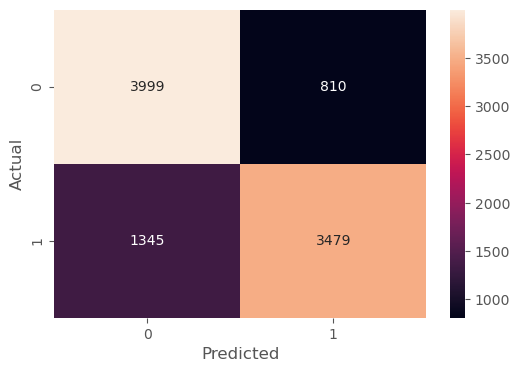

              precision    recall  f1-score   support

           0       0.75      0.83      0.79      4809
           1       0.81      0.72      0.76      4824

    accuracy                           0.78      9633
   macro avg       0.78      0.78      0.78      9633
weighted avg       0.78      0.78      0.78      9633



In [29]:
y_pred = y_LR

# Crear matriz de confusión
conf_mat = confusion_matrix(y_test, y_pred)

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(6,4))

# Crear mapa de calor de la matriz de confusión con Seaborn
sns.heatmap(conf_mat
            , annot=True  # agregar valores en cada celda
            , fmt='d'    # formato de los valores (d = decimal)
           )

# Agregar etiquetas a los ejes x e y
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Mostrar la figura
plt.show()

# Se imprimen las medidas de rendimiento del modelo
print(metrics.classification_report(y_test, y_pred))

#### ROC - Receiver Operating Characteristic

0.86: LogisticRegression()
0.86: SVC(kernel='linear', probability=True)
0.66: SVC(degree=2, kernel='poly', probability=True)
0.83: SVC(kernel='poly', probability=True)
0.85: SVC(probability=True)
0.70: SVC(kernel='sigmoid', probability=True)
0.61: KNeighborsClassifier()
0.70: DecisionTreeClassifier()
0.85: RandomForestClassifier()
0.87: MLPClassifier()


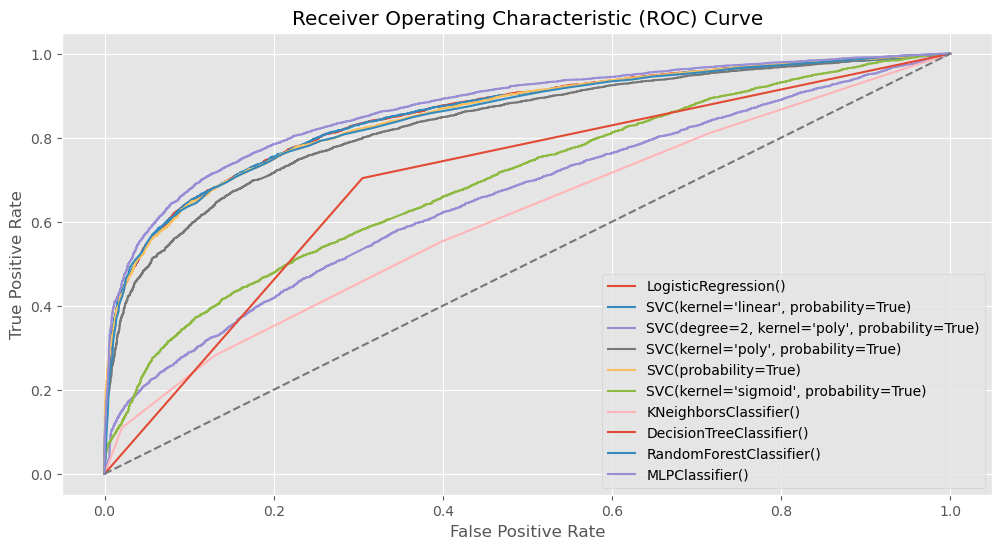

In [32]:
# Crear figura de tamaño 10x6
fig = plt.figure(figsize=(12, 6))  

# Lista de modelos a evaluar
Modelos = [modelLR, modelSVC_lin, modelSVC_pol2, modelSVC_pol3, modelSVC_rbf, modelSVC_sig,    modelknn, modelTreeClas, modelRanForest, ModelNN]  

# Iterar sobre los modelos
for i in range(len(Modelos)):
    
    # Obtener probabilidades de predicción del modelo
    probs = Modelos[i].predict_proba(X_test)  
    
    # Seleccionar la columna correspondiente a la probabilidad de clase positiva
    probs = probs[:, 1]  

    # Calcular el AUC-ROC
    auc = roc_auc_score(y_test, probs*(1))  

    # Calcular las tasas de FPR y TPR
    fpr, tpr, _ = roc_curve(y_test, probs*(1))  

    # Graficar la curva ROC del modelo actual
    plt.plot(fpr, tpr, label=Modelos[i])  

    # Mostrar el AUC-ROC y el nombre del modelo
    print("{:.2f}: {}".format(auc, Modelos[i]))  


# Graficar la línea diagonal punteada (clasificador aleatorio)
plt.plot([0, 1], [0, 1], linestyle='--')  
plt.xlabel('False Positive Rate')  # Etiqueta del eje x
plt.ylabel('True Positive Rate')  # Etiqueta del eje y
plt.title('Receiver Operating Characteristic (ROC) Curve')  # Título del gráfico
plt.legend()  # Mostrar la leyenda de los modelos
plt.show()  # Mostrar el gráfico


In [33]:
print("="*5 + f" Accuracy de los modelos " + "="*20)
print()
print("modelLR       :",metrics.accuracy_score(y_test, y_LR       ))
print("modelSVC_lin  :",metrics.accuracy_score(y_test, y_SVC_lin  ))
print("modelSVC_pol2  :",metrics.accuracy_score(y_test, y_SVC_pol2))
print("modelSVC_pol3  :",metrics.accuracy_score(y_test, y_SVC_pol3))
print("modelSVC_rbf  :",metrics.accuracy_score(y_test, y_SVC_rbf  ))
print("modelSVC_sig  :",metrics.accuracy_score(y_test, y_SVC_sig  ))
print("modelknn      :",metrics.accuracy_score(y_test, y_knn      ))
print("modelTreeClas :",metrics.accuracy_score(y_test, y_TreeClas ))
print("modelRanForest:",metrics.accuracy_score(y_test, y_RanForest))
print("ModelNN       :",metrics.accuracy_score(y_test, y_NN      ))

===== Accuracy de los modelos ====================

modelLR       : 0.776289837018582
modelSVC_lin  : 0.7754593584553099
modelSVC_pol2  : 0.6133084189764352
modelSVC_pol3  : 0.7590574068306862
modelSVC_rbf  : 0.776186027198173
modelSVC_sig  : 0.6327208553929202
modelknn      : 0.5770787916536905
modelTreeClas : 0.699470569915914
modelRanForest: 0.7753555486349009
ModelNN       : 0.7937298868472957


In [36]:
# Datos
datos = {
    'Método': ['modelLR', 'modelSVMlin', 'modelSVMpoly2','modelSVMpoly3', 'modelSVMrbf',  'modelSVMsig', 'modelknn', 'modelComplNB', 'modelRanForest', 'ModelNN'],
    'Accuracy':[metrics.accuracy_score(y_test, y_LR), metrics.accuracy_score(y_test, y_SVC_lin), metrics.accuracy_score(y_test, y_SVC_pol2), metrics.accuracy_score(y_test, y_SVC_pol3), metrics.accuracy_score(y_test, y_SVC_rbf) ,metrics.accuracy_score(y_test, y_SVC_sig  ), metrics.accuracy_score(y_test, y_knn),  metrics.accuracy_score(y_test, y_TreeClas), metrics.accuracy_score(y_test, y_RanForest), metrics.accuracy_score(y_test, y_NN)],
    'AUC': [metrics.roc_auc_score(y_test, y_LR), metrics.roc_auc_score(y_test, y_SVC_lin), metrics.roc_auc_score(y_test, y_SVC_pol2), metrics.roc_auc_score(y_test, y_SVC_pol3), metrics.roc_auc_score(y_test, y_SVC_rbf) ,metrics.roc_auc_score(y_test, y_SVC_sig  ), metrics.roc_auc_score(y_test, y_knn), metrics.roc_auc_score(y_test, y_TreeClas), metrics.roc_auc_score(y_test, y_RanForest), metrics.roc_auc_score(y_test, y_NN)]
}

# Crear un DataFrame
df = pd.DataFrame(datos)
df


,Método,Accuracy,AUC
0,modelLR,0.7763,0.7764
1,modelSVMlin,0.7755,0.7756
2,modelSVMpoly2,0.6133,0.6136
3,modelSVMpoly3,0.7591,0.7592
4,modelSVMrbf,0.7762,0.7763
5,modelSVMsig,0.6327,0.6327
6,modelknn,0.5771,0.5771
7,modelComplNB,0.6995,0.6995
8,modelRanForest,0.7754,0.7754
9,ModelNN,0.7937,0.7938


#### Referencias


- Random Forest
    - https://www.cienciadedatos.net/documentos/py08_random_forest_python.html
    - https://fhernanb.github.io/libro_mod_pred/rand-forests.html
    - https://quantdare.com/decision-trees-gini-vs-entropy/
    

#### Referencias


- Maquinas de vectores de soporte

    - https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python


- *scikit-learn:*   
    - https://scikit-learn.org/stable/modules/svm.html
    
    ROC
    - https://stackabuse.com/understanding-roc-curves-with-python/



- *Gráficas con  seaborn:*
    - https://ichi.pro/es/como-utilizar-python-seaborn-para-analisis-de-datos-exploratorios-28897898172180



- *Analítica de grandes datos:*
    - https://jdvelasq.github.io/courses/analitica-de-grandes-datos/index.html